In [28]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np
import tensorflow as tf
import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPooling1D, GlobalMaxPooling1D
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from sklearn.preprocessing import LabelEncoder

## **1. Load the dataset**

In [3]:
%cd /content/drive/MyDrive/Colab
# load data from csv 
dataset = pd.read_csv('FinalDatasetwithpeprosing.csv')
dataset.info()

/content/drive/MyDrive/Colab
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15309 entries, 0 to 15308
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   content    15291 non-null  object
 1   sentiment  15309 non-null  object
dtypes: object(2)
memory usage: 239.3+ KB


In [4]:
import pandas as pd

# Replace null values in the 'content' column with 'missing'
dataset['content'].fillna('missing', inplace=True)

# Check the dataset info to verify that there are no null values
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15309 entries, 0 to 15308
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   content    15309 non-null  object
 1   sentiment  15309 non-null  object
dtypes: object(2)
memory usage: 239.3+ KB


## **2. Split the dataset with the ratio of 70:15:15**

In [5]:
import pandas as pd
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Embedding, Conv1D, MaxPooling1D, Flatten, Dense, Dropout,  BatchNormalization


# convert sentiment labels to integers
sentiment_labels, _ = pd.factorize(dataset['sentiment'])

# split the dataset into train, validation, and test sets
train_contents, test_contents, train_sentiments, test_sentiments = train_test_split(
    dataset['content'], sentiment_labels, test_size=0.15, random_state=42)
train_contents, val_contents, train_sentiments, val_sentiments = train_test_split(
    train_contents, train_sentiments, test_size=0.1764, random_state=42)


## **3. Check the voca size to put in the model & make it tokenization**

In [6]:
from tensorflow.keras.preprocessing.text import Tokenizer

# Create a tokenizer object and fit on the text data
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_contents)

# Get the vocabulary size
vocab_size = len(tokenizer.word_index) + 1  # add 1 for the padding token

print("Vocabulary size:", vocab_size)

Vocabulary size: 14136


In [7]:
# Convert text to numerical sequences
train_sequences = tokenizer.texts_to_sequences(train_contents)
val_sequences = tokenizer.texts_to_sequences(val_contents)
test_sequences = tokenizer.texts_to_sequences(test_contents)

## **4. Check the maximum sequence length to put in the model & pad by the max. length**


In [8]:
max_length = 0
for seq in train_contents:
    if isinstance(seq, str) or isinstance(seq, list):
        if len(seq) > max_length:
            max_length = len(seq)

print("Maximum sequence length:", max_length)

Maximum sequence length: 152


In [9]:
# Pad sequences to have the same length
MAX_SEQUENCE_LENGTH = max_length
train_data = pad_sequences(train_sequences, maxlen=MAX_SEQUENCE_LENGTH)
val_data = pad_sequences(val_sequences, maxlen=MAX_SEQUENCE_LENGTH)
test_data = pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH)

## **5. Check the embedded size to put in the model**


In [10]:
from gensim.models import Word2Vec

# Filter out float values from train_contents
train_contents = [text for text in train_contents if isinstance(text, str)]

# Train Word2Vec model on text data
model = Word2Vec(sentences=train_contents, vector_size=300, window=5, min_count=1, workers=4)

# Get the embedding size
embed_size = model.vector_size

print("Embedding size:", embed_size)

Embedding size: 300


In [11]:
# convert the labels to one-hot encoded vectors
NUM_CLASSES = 7
train_sentiments = to_categorical(train_sentiments, NUM_CLASSES)
val_sentiments = to_categorical(val_sentiments, NUM_CLASSES)
test_sentiments = to_categorical(test_sentiments, NUM_CLASSES)

## **6. Experiment the CNN model**

In [12]:
# build the CNN model
VOCAB_SIZE = vocab_size
EMBED_SIZE = embed_size
MAX_SEQUENCE_LENGTH = max_length

from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint

model = Sequential([
    Embedding(VOCAB_SIZE, EMBED_SIZE, input_length=MAX_SEQUENCE_LENGTH),
    Conv1D(64, 5, activation='relu'),
    GlobalMaxPooling1D(),
    Dropout(0.5),
    Dense(16, activation='relu'),
    Dropout(0.5),
    Dense(7, activation='softmax')
])


model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.Adam(learning_rate=0.0001), metrics=['accuracy'])

filepath='/tmp/weights_modified.{epoch:02d}-{val_loss:.2f}.hdf5'
checkpoint=tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=0, save_best_only=False, save_weights_only=False, mode='auto', save_freq='epoch')


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 152, 300)          4240800   
                                                                 
 conv1d (Conv1D)             (None, 148, 64)           96064     
                                                                 
 global_max_pooling1d (Globa  (None, 64)               0         
 lMaxPooling1D)                                                  
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 16)                1040      
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                        

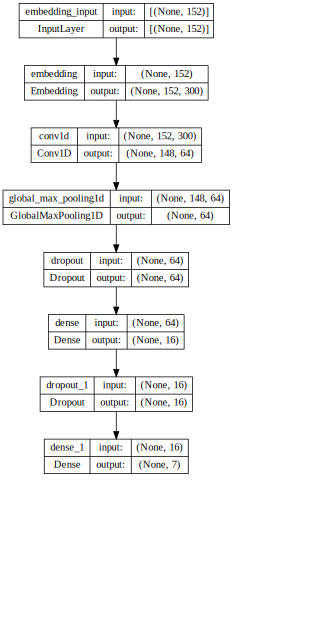

In [27]:
from keras.utils import plot_model
from keras.utils.vis_utils import model_to_dot
from IPython.display import HTML, display, clear_output, SVG

#Display Model Summary
model.summary()

plot_model(model, to_file='model.png', show_layer_names=True, show_shapes=True, rankdir='TB')
SVG(model_to_dot(model, show_layer_names=True, show_shapes=True, rankdir='TB').create(prog='dot', format='svg'))

In [13]:
# train the model
EPOCHS = 60
BATCH_SIZE = 128

history = model.fit(train_data, train_sentiments, epochs=EPOCHS, batch_size=BATCH_SIZE,
                    validation_data=(val_data, val_sentiments), callbacks=[checkpoint])

# Save training history to CSV
history_df = pd.DataFrame(history.history)
history_df.to_csv('training_history.csv', index=False)

Epoch 1/60
84/84 [==============================] - 39s 458ms/step - loss: 1.9484 - accuracy: 0.1439 - val_loss: 1.9430 - val_accuracy: 0.1838
Epoch 2/60
84/84 [==============================] - 33s 398ms/step - loss: 1.9434 - accuracy: 0.1587 - val_loss: 1.9405 - val_accuracy: 0.2003
Epoch 3/60
84/84 [==============================] - 36s 428ms/step - loss: 1.9372 - accuracy: 0.1793 - val_loss: 1.9368 - val_accuracy: 0.2199
Epoch 4/60
84/84 [==============================] - 33s 397ms/step - loss: 1.9295 - accuracy: 0.1982 - val_loss: 1.9311 - val_accuracy: 0.2439
Epoch 5/60
84/84 [==============================] - 34s 400ms/step - loss: 1.9222 - accuracy: 0.2032 - val_loss: 1.9249 - val_accuracy: 0.2461
Epoch 6/60
84/84 [==============================] - 35s 416ms/step - loss: 1.9128 - accuracy: 0.2146 - val_loss: 1.9170 - val_accuracy: 0.2552
Epoch 7/60
84/84 [==============================] - 33s 399ms/step - loss: 1.9005 - accuracy: 0.2295 - val_loss: 1.9068 - val_accuracy: 0.2648

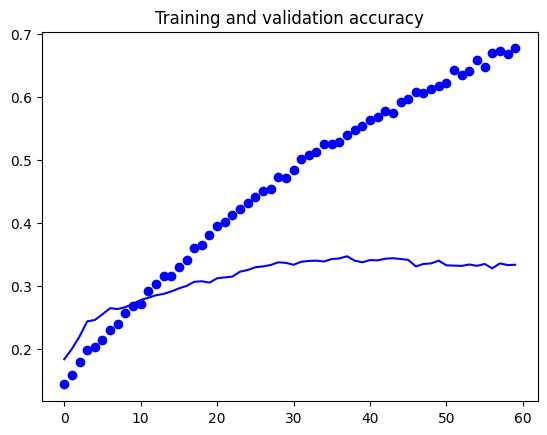

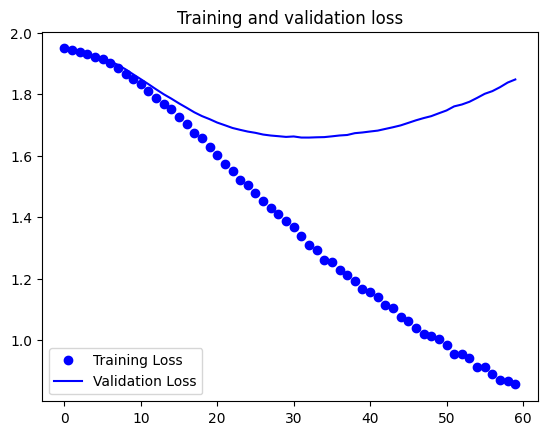

In [21]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

## **7. Check the test accuracy**

In [22]:
# evaluate the model
test_loss, test_acc = model.evaluate(test_data, test_sentiments)
print('Test loss:', test_loss)
print('Test accuracy:', test_acc)

72/72 [==============================] - 2s 32ms/step - loss: 1.8827 - accuracy: 0.3182
Test loss: 1.8827202320098877
Test accuracy: 0.3182411789894104


In [23]:
# Print the unique values in the original label column
print("Unique labels in the dataset['sentiment'] column:", dataset['sentiment'].unique())

# Print the unique values in the encoded label column
print("Unique labels in the encoded labels:", [i for i in range(NUM_CLASSES)])

Unique labels in the dataset['sentiment'] column: ['anger' 'happiness' 'love' 'neutral' 'sadness' 'surprise' 'worry']
Unique labels in the encoded labels: [0, 1, 2, 3, 4, 5, 6]


## **8. Pick the 5 random samples**

In [24]:
import random

# define a list of emotion labels
emotions = ['anger', 'happiness', 'love', 'neutral', 'sadness', 'surprise', 'worry']

# randomly choose 5 samples from the test set
random_indices = random.sample(range(len(test_contents)), 5)

# make predictions on the randomly chosen samples
y_pred = model.predict(test_data[random_indices])

# convert the one-hot encoded predictions to class labels
y_pred_labels = np.argmax(y_pred, axis=1)

# classify the emotions in the randomly chosen samples
count = 1
for i in random_indices:
    print(f"{count}.", 'Text:', test_contents.iloc[i])
    print('   True emotion:', emotions[np.argmax(test_sentiments[i])])
    print('   Predicted emotion:', emotions[y_pred_labels[count - 1]])
    print()
    count += 1


1/1 [==============================] - 0s 30ms/step
1. Text: Fyi- putting makeup on under flourescents = FAIL. ... oh face-peely, why must you look so hideous? Also, wheres my lipstick?
   True emotion: worry
   Predicted emotion: anger

2. Text:  FML dad didnt leave me any moneyz, so i have 2 wait till he gets home   call me when you finish work?
   True emotion: sadness
   Predicted emotion: sadness

3. Text: Eating some ice cream cake  its bomb!
   True emotion: surprise
   Predicted emotion: happiness

4. Text:  Italy or greece for me  Love Italian men hehe ;)
   True emotion: happiness
   Predicted emotion: love

5. Text:  Why?
   True emotion: neutral
   Predicted emotion: neutral



## **9. Check the confusion Matrix**

72/72 [==============================] - 3s 36ms/step


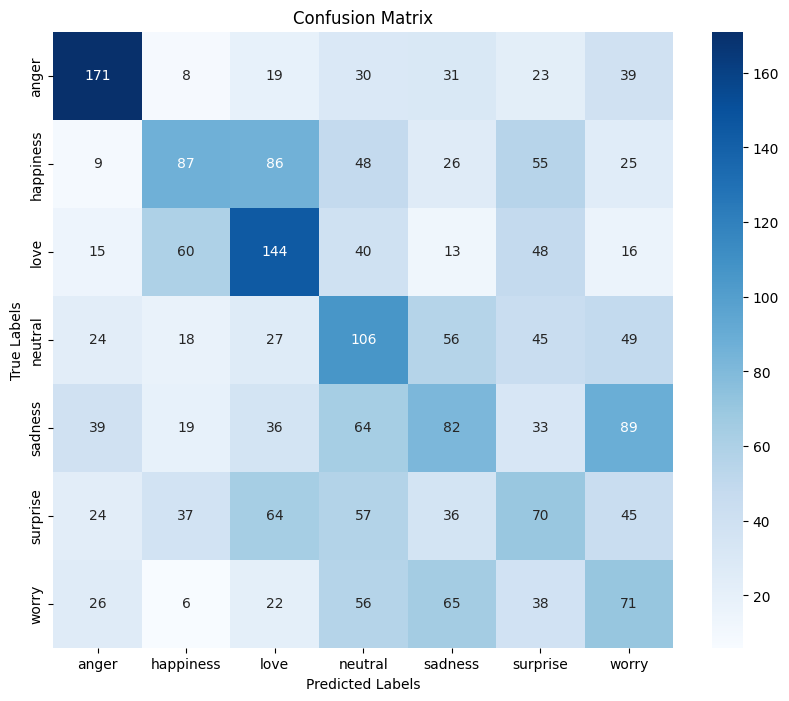

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# predict on test set
y_pred = model.predict(test_data)

# define a list of emotion labels
emotions = ['anger', 'happiness', 'love', 'neutral', 'sadness', 'surprise', 'worry']

# get the true labels and predicted labels
true_labels = np.argmax(test_sentiments, axis=1)
pred_labels = np.argmax(y_pred, axis=1)

# calculate the confusion matrix
cm = confusion_matrix(true_labels, pred_labels)

# set the figure size
plt.figure(figsize=(10, 8))

# plot the confusion matrix
sns.heatmap(cm, annot=True, cmap='Blues', xticklabels=emotions, yticklabels=emotions, fmt='g')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


## **10. Check the classification Report**

In [19]:
from sklearn.metrics import classification_report

# get the true labels and predicted labels
true_labels = np.argmax(test_sentiments, axis=1)
pred_labels = np.argmax(y_pred, axis=1)

# print the classification report
print(classification_report(true_labels, pred_labels, target_names=emotions))


              precision    recall  f1-score   support

       anger       0.56      0.53      0.54       321
   happiness       0.37      0.26      0.30       336
        love       0.36      0.43      0.39       336
     neutral       0.26      0.33      0.29       325
     sadness       0.27      0.23      0.24       362
    surprise       0.22      0.21      0.22       333
       worry       0.21      0.25      0.23       284

    accuracy                           0.32      2297
   macro avg       0.32      0.32      0.32      2297
weighted avg       0.32      0.32      0.32      2297



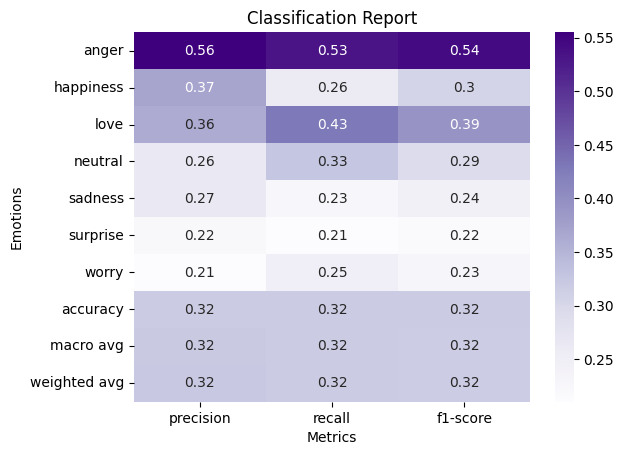

In [20]:
from sklearn.metrics import classification_report

# get the true labels and predicted labels
true_labels = np.argmax(test_sentiments, axis=1)
pred_labels = np.argmax(y_pred, axis=1)

# get the classification report
report = classification_report(true_labels, pred_labels, target_names=emotions, output_dict=True)

# plot the classification report
sns.heatmap(pd.DataFrame(report).iloc[:-1, :].T, annot=True, cmap='Purples')
plt.xlabel('Metrics')
plt.ylabel('Emotions')
plt.title('Classification Report')
plt.show()
